In [19]:
!pip install -U pip
!pip install -U matplotlib numpy keras tensorflow shap

  Using cached keras-3.0.4-py3-none-any.whl.metadata (4.8 kB)
  Using cached rich-13.7.0-py3-none-any.whl.metadata (18 kB)
  Using cached namex-0.0.7-py3-none-any.whl (5.8 kB)
  Using cached dm_tree-0.1.8-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (152 kB)
  Using cached markdown_it_py-3.0.0-py3-none-any.whl.metadata (6.9 kB)
  Using cached mdurl-0.1.2-py3-none-any.whl (10.0 kB)


In [36]:
import os

import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import shap
import tensorflow as tf

from keras.applications.vgg16 import preprocess_input
from keras.models import load_model

## Load Data

In [21]:
X_train = np.load(os.path.join('..', 'Arrays', 'VGG16', 'x_train.npy'))
y_train = np.load(os.path.join('..', 'Arrays', 'VGG16', 'y_train.npy'))
X_test = np.load(os.path.join('..', 'Arrays', 'VGG16', 'x_test.npy'))
y_test = np.load(os.path.join('..', 'Arrays', 'VGG16', 'y_test.npy'))
X_val = np.load(os.path.join('..', 'Arrays', 'VGG16', 'x_val.npy'))
y_val = np.load(os.path.join('..', 'Arrays', 'VGG16', 'y_val.npy'))

X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((13576, 224, 224, 3),
 (13576, 9),
 (1938, 224, 224, 3),
 (1938, 9),
 (3879, 224, 224, 3),
 (3879, 9))

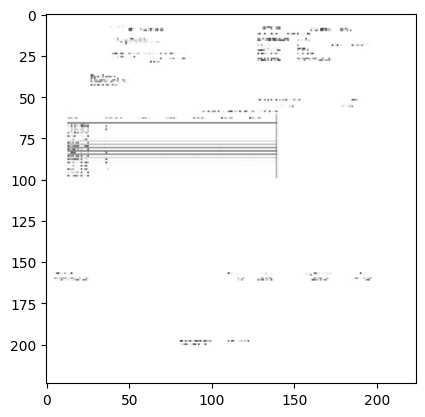

In [22]:
plt.imshow(X_test[0])
plt.show()

## Load Model

In [25]:
model = load_model(os.path.join('..', 'models', 'VGG16', 'trained_model_all_layer_100epochs_10_5.h5'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 predictions (Dense)         (None, 9)                 1161      
                                                                 
Total params: 17927241 (68.39 MB)
Trainable params: 17927241 (68.39 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
model.get_layer('vgg16').layers

In [38]:
to_explain = [X_test[0]]

def map2layer(x, layer):
    feed_dict = dict(zip([model.get_layer('vgg16').layers[0].input.ref()], [preprocess_input(x.copy())]))
    return tf.compat.v1.keras.backend.get_session().run(model.get_layer('vgg16').layers[layer].input, feed_dict)


e = shap.GradientExplainer(
    (model.get_layer('vgg16').layers[7].input, model.layers[-1].output),
    map2layer(preprocess_input(X_test.copy()), 7),
)
shap_values, indexes = e.shap_values(map2layer(to_explain, 7), ranked_outputs=None)  # 

# get the names for the classes
# index_names = np.vectorize(lambda x: class_names[str(x)][1])(indexes)

# plot the explanations
shap.image_plot(shap_values, to_explain)  # , index_names

RuntimeError: The Session graph is empty. Add operations to the graph before calling run().